In [1]:
!pip install opencv-python
!pip install dlib
!pip install imutils

import cv2
import numpy as np
import utils
import scipy
import scipy.sparse.linalg
import dlib
import imutils
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [38]:
class FilterImage:
    def __init__(self, image_path):
        self.filter_img = cv2.imread(image_path)
        self.mask_coords = None
        self.mask = None
        self.features = None
        
    def prompt_set_mask(self):
        import matplotlib.pyplot as plt
        %matplotlib notebook
        self.mask_coords = utils.specify_mask(self.filter_img)
        
    def assign_mask(self):
        %matplotlib inline
        import matplotlib.pyplot as plt
        xs = self.mask_coords[0]
        ys = self.mask_coords[1]
        plt.figure()
        self.mask = utils.get_mask(ys, xs, self.filter_img)
        
    def prompt_feature_selection(self, num_points=3):
        # switch from notebook to inline if using colab or otherwise cannot use interactive display)
        %matplotlib notebook  
        import matplotlib.pyplot as plt
        
        fig = plt.figure()
        plt.imshow(self.filter_img, cmap='gray')
        fig.set_label(f"Click on {num_points} points for alignment")
        plt.axis('off')
        xs = []
        ys = []
        clicked = np.zeros((num_points, 2), dtype=np.float32)

        # Define a callback function that will update the textarea
        def onmousedown(event):
            x = event.xdata
            y = event.ydata
            xs.append(x)
            ys.append(y)

            plt.plot(x, y, 'r-+')
    #         plt.plot(xs, ys, 'r-+')

        def onmouseup(event):
            if(len(xs) >= num_points):
                plt.close(fig)

        def onclose(event):
            clicked[:, 0] = xs
            clicked[:, 1] = ys
        # Create an hard reference to the callback not to be cleared by the garbage
        # collector
        fig.canvas.mpl_connect('button_press_event', onmousedown)
        fig.canvas.mpl_connect('button_release_event', onmouseup)
        fig.canvas.mpl_connect('close_event', onclose)
        
        self.features = clicked
        return clicked


In [42]:
img = FilterImage('mustache.jpg')

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


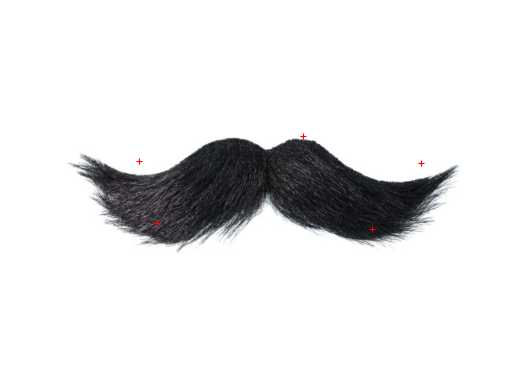

In [44]:
img.prompt_set_mask()

<Figure size 432x288 with 0 Axes>

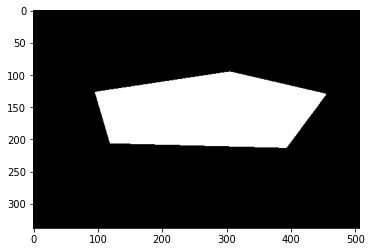

In [45]:
img.assign_mask()

<IPython.core.display.Javascript object>


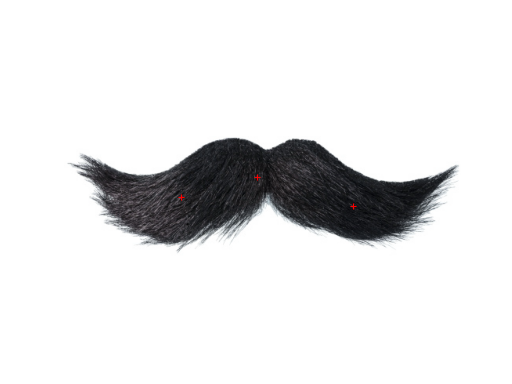

array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [46]:
img.prompt_feature_selection()

array([[209.20099, 406.0342 ],
       [426.4793 , 350.727  ],
       [659.5597 , 421.83627]], dtype=float32)

In [175]:

def prompt_point_selection(image, size):
    fig = plt.figure()
    plt.imshow(image, cmap='gray')
    fig.set_label('Click on two points for alignment')
    plt.axis('off')
    xs = []
    ys = []
    clicked = np.zeros((size, 2), dtype=np.float32)

    # Define a callback function that will update the textarea
    def onmousedown(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)

        plt.plot(x, y, 'r-+')

    def onmouseup(event):
        if(len(xs) >= 2):
            plt.close(fig)

    def onclose(event):
        clicked[:, 0] = xs
        clicked[:, 1] = ys
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', onmousedown)
    fig.canvas.mpl_connect('button_release_event', onmouseup)
    fig.canvas.mpl_connect('close_event', onclose)

    return clicked

In [7]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib notebook  
import matplotlib.pyplot as plt

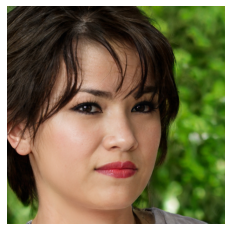

In [109]:
person = cv2.cvtColor(cv2.imread('thispersondoesnotexist.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
person_output = prompt_point_selection(person, 3)

In [174]:
person_output

array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

<IPython.core.display.Javascript object>


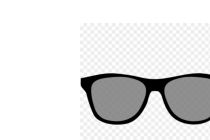

In [149]:
sunglasses = cv2.imread('sunglasses.png')

output_points = prompt_eye_selection(sunglasses)

In [148]:
start = output_points
end = person_output

M = cv2.getAffineTransform(start,end)
# rotation = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)

# scale = np.sqrt(end**2 - start**2)
# translation = 

# transform = cv2.getPerspectiveTransform(start, end)
warp = cv2.warpAffine(sunglasses, M, person.shape[:2])

plt.figure()
plt.imshow(warp)

[[0. 0.]
 [0. 0.]]
(2, 2) (3, 2)


error: OpenCV(4.5.4) /tmp/pip-req-build-kv0l0wqx/opencv/modules/imgproc/src/imgwarp.cpp:3399: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 3 && dst.checkVector(2, CV_32F) == 3 in function 'getAffineTransform'


If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


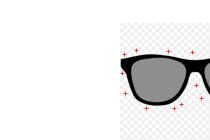

In [30]:
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = utils.specify_mask(sunglasses)

(859, 840)


<Figure size 432x288 with 0 Axes>

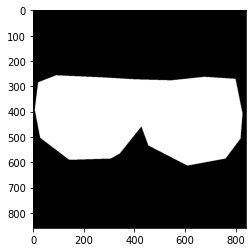

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
xs = mask_coords[0]
ys = mask_coords[1]
plt.figure()
object_mask = utils.get_mask(ys, xs, sunglasses)

print(object_mask.shape)

object_mask_warp_3d = np.zeros((object_mask.shape[0], object_mask.shape[1], 3))
object_mask_warp_3d[:, :, 0] = object_mask
object_mask_warp = cv2.warpAffine(object_mask_warp_3d, M, person.shape[:2])[:, :, 0]

In [7]:
def get_neighbors(i, j):
    return [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO   
    object_img_shift = np.zeros(bg_img.shape, dtype='double')
    mask_shift = np.zeros(bg_img.shape)
            
    a, b = np.where(object_mask==1)
    
    mask_indices = list(zip(a, b))
    
    im_w, im_h = bg_img.shape
    m = len(mask_indices) * 4
    n = im_w * im_h
    
    A = scipy.sparse.lil_matrix((m, n))
    b = np.zeros(m)
    
    print('A shape:', A.shape)
    
    # Step 2
    im2var = np.arange(im_w * im_h).reshape(im_w, im_h)
    print('im2var shape', im2var.shape)
    
    e = -1
    for x, y in mask_indices:
        for n_x, n_y in get_neighbors(x, y):
            e += 1
            
            A[e, im2var[x][y]] = 1
            
            object_grad = object_img[x, y] - object_img[n_x, n_y]
            bg_grad = bg_img[x, y] - bg_img[n_x, n_y]
            
            grad = object_grad if abs(object_grad) > abs(bg_grad) else bg_grad

            if object_mask[n_x][n_y] == 1:
                A[e, im2var[n_x][n_y]] = -1
                b[e] = grad
                
            else:
                b[e] = grad + bg_img[n_x, n_y]

    A = scipy.sparse.csr_matrix(A)
    v = scipy.sparse.linalg.lsqr(A, b)[0]
    
    to_return = bg_img * (1 - object_mask)
#     v[v<0] = 0
#     v[v>1] = 1
    
    for x, y in mask_indices:
        to_return[x, y] += v[im2var[x][y]]
    return to_return


In [8]:
im_mix = np.zeros(person.shape)

for b in np.arange(3):
    im_mix[:,:,b] = mixed_blend(warp[:,:,b].astype('double') / 255, object_mask_warp, person[:,:,b].copy(), (0, 0))

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

NameError: name 'person' is not defined

In [36]:
# Class that 
class ObjectFilter:
    def __init__(self, predictor, object_filter):
        self.predictor = predictor
        self.object_filter = object_filter

    def place_object(self, face):
        facial_features = self.predictor(face, rect)
        facial_features = shape_to_np(facial_features)
                
#         features = np.array([facial_features[39], facial_features[31], facial_features[44]]).astype('float32')
        features = np.array([facial_features[48], facial_features[51], facial_features[54]]).astype('float32')
#         features = np.array([facial_features[48], facial_features[51], facial_features[54], facial_features[58]]).astype('float32')
    
        plt.figure()
        plt.plot(features[0][0], features[0][1], marker='v', color="white")
        plt.plot(features[1][0], features[1][1], marker='v', color="red")
        plt.plot(features[2][0], features[2][1], marker='v', color="blue")
#         plt.plot(features[3][0], features[3][1], marker='v', color="green")


        plt.imshow(face)

        object_warp, mask_warp = self.get_warps(features.copy(), face)
        
        face = face.astype('double') / 255.0
        im_mix = np.zeros(face.shape)

        for b in np.arange(3):
            im_mix[:,:,b] = self.mixed_blend(object_warp[:,:,b].astype('double') / 255, mask_warp, face[:,:,b].copy(), (0, 0))

        return im_mix
    
    def get_warps(self, features, face):
        start = self.object_filter.features
        end = features
        
        print(start)
        print(end)
        
#         M = cv2.getPerspectiveTransform(start, end)
#         warp_object_filter = cv2.warpPerspective(self.object_filter.filter_img, M, face.shape[:2], flags=cv2.INTER_LINEAR)
        
        M = cv2.getAffineTransform(start, end)
        warp_object_filter = cv2.warpPerspective(self.object_filter.filter_img, M, face.shape[:2])
        
        object_mask_warp_3d = np.zeros((self.object_filter.mask.shape[0], self.object_filter.mask.shape[1], 3))
        object_mask_warp_3d[:, :, 0] = self.object_filter.mask
#         object_mask_warp = cv2.warpPerspective(object_mask_warp_3d, M, face.shape[:2])[:, :, 0]
        object_mask_warp = cv2.warpAffine(object_mask_warp_3d, M, face.shape[:2])[:, :, 0]
        
        plt.figure()
        plt.imshow(warp_object_filter)
        
        return warp_object_filter, object_mask_warp

    def get_neighbors(self, i, j):
        return [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

    def mixed_blend(self, object_img, object_mask, bg_img, bg_ul):
        """
        Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
        Can be implemented to operate on a single channel or multiple channels
        :param object_img: the image containing the foreground object
        :param object_mask: the mask of the foreground object in object_img
        :param background_img: the background image 
        :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
        """
        #TO DO   
        object_img_shift = np.zeros(bg_img.shape, dtype='double')
        mask_shift = np.zeros(bg_img.shape)

        a, b = np.where(object_mask==1)

        mask_indices = list(zip(a, b))

        im_w, im_h = bg_img.shape
        m = len(mask_indices) * 4
        n = im_w * im_h

        A = scipy.sparse.lil_matrix((m, n))
        b = np.zeros(m)

        print('A shape:', A.shape)

        # Step 2
        im2var = np.arange(im_w * im_h).reshape(im_w, im_h)
        print('im2var shape', im2var.shape)

        e = -1
        for x, y in mask_indices:
            for n_x, n_y in self.get_neighbors(x, y):
                e += 1

                A[e, im2var[x][y]] = 1

                object_grad = object_img[x, y] - object_img[n_x, n_y]
                bg_grad = bg_img[x, y] - bg_img[n_x, n_y]

                grad = object_grad if abs(object_grad) > abs(bg_grad) else bg_grad

                if object_mask[n_x][n_y] == 1:
                    A[e, im2var[n_x][n_y]] = -1
                    b[e] = grad

                else:
                    b[e] = grad + bg_img[n_x, n_y]

        A = scipy.sparse.csr_matrix(A)
        v = scipy.sparse.linalg.lsqr(A, b)[0]

        to_return = bg_img * (1 - object_mask)
    #     v[v<0] = 0
    #     v[v>1] = 1

        for x, y in mask_indices:
            to_return[x, y] += v[im2var[x][y]]
        return to_return
    

In [10]:
# Helper Functions

from collections import OrderedDict

FACIAL_LANDMARKS_68_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("left_eye", (36, 42)),
    ("right_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    return coords

def bounding_box(points):
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)
    return (min_x, min_y, (max_x - min_x), (max_y - min_y))

In [11]:
# Classifiers
eye_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

dlib_face_detector = dlib.get_frontal_face_detector()
dlib_shape_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")



<IPython.core.display.Javascript object>


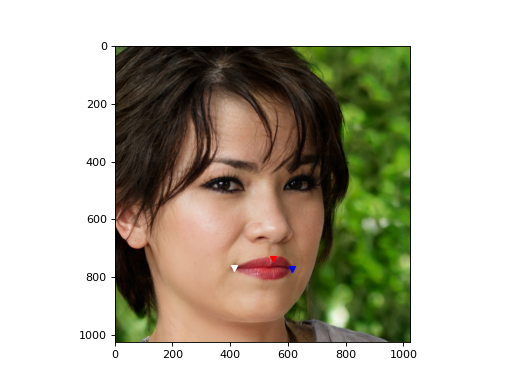

[[149.40231 171.9243 ]
 [245.48698 147.39203]
 [368.1483  184.19043]]
[[412. 769.]
 [548. 738.]
 [613. 770.]]


error: OpenCV(4.5.4) /tmp/pip-req-build-kv0l0wqx/opencv/modules/imgproc/src/imgwarp.cpp:3168: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


In [47]:
face = cv2.cvtColor(cv2.imread('thispersondoesnotexist.jpeg'), cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
rects = dlib_face_detector(gray, 2)
rect = rects[0]

of = ObjectFilter(dlib_shape_predictor, img)

output = of.place_object(face)

plt.figure()
plt.imshow(output)


# for rect in rects:
#     (x, y, w, h) = rect_to_bb(rect)
    
#     img_result = of.place_object(face, rect)
#     plt.imshow(img_result)


In [67]:
output[output > 1] = 1
output[output < 0] = 0

plt.figure()
plt.imshow(output)
plt.imsave('filterMustache.jpg', output.astype('float'))

<IPython.core.display.Javascript object>